In [16]:
%load_ext autoreload
%autoreload 2

In [15]:
import numpy as np
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from forecastTable import forecastTable
from columnCleaner import columnCleaner

In [9]:
observations = pd.read_csv("data/observations_train.csv")
series = pd.read_csv("data/series.csv")
test_obs = pd.read_csv("data/observations_test.csv")
series.head()

,series_id,name,frequency,units,seasonal_adjustment,Description
0,AAA10Y,Moodys Seasoned Aaa Corporate Bond Yield Relat...,Daily,Percent,Not Seasonally Adjusted,Series is calculated as the spread between Moo...
1,ASEANTOT,Import Price Index: ASEAN - All commodities,Monthly,Index Dec 2003=100,Not Seasonally Adjusted,"For more information, please see the Import/Ex..."
2,BAA10Y,Moodys Seasoned Baa Corporate Bond Yield Relat...,Daily,Percent,Not Seasonally Adjusted,Series is calculated as the spread between Moo...
3,BUSAPPWNSAUS,Business Applications for the United States,"Weekly, Ending Saturday",Number,Not Seasonally Adjusted,Business Applications (BA): The core business ...
4,BUSAPPWNSAUSYY,Business Applications for the United States,"Weekly, Ending Saturday",Percent Change from Year Ago,Not Seasonally Adjusted,Business Applications (BA): The core business ...


In [3]:
observations['date'] = pd.to_datetime(observations['date'])
obs = observations.pivot_table(values="value", index="date", columns="series_id")

In [4]:
SP500 = obs['SP500']
SP500.dropna(inplace=True)
SP500.head()

date
2011-02-14    1332.32
2011-02-15    1328.01
2011-02-16    1336.32
2011-02-17    1340.43
2011-02-18    1343.01
Name: SP500, dtype: float64

In [5]:
normalize = lambda col: (col-col.mean())/col.std()

normed_obs = obs.apply(normalize, axis=0)

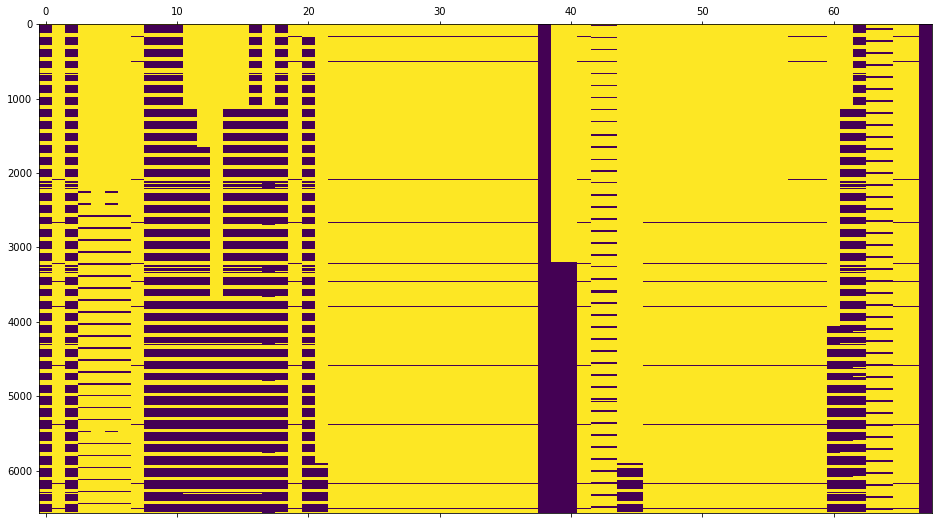

In [8]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.matshow(normed_obs.isna().to_numpy(), aspect='auto')

This is a map of all the NaN values in the dataset (in yellow). We can see the relative frequencies of each series (columns), as well as when the majority of them start (rows). Column 60 is the S&P500, showing that we can filter out roughly the top half of this dataset with no repurcussions (since those features are useless to learn on without a target S&P500 value).

# Large Model Factor Analysis

In [99]:
cols = list(set(series['series_id'].unique()) - set(['SP500']))

features, mu, s = columnCleaner("data/observations_train.csv", columns=cols, normalize_sp5=False)
features.head()

Dropping Column: DEXJPUS
Dropping Column: SOFRVOL
Dropping Column: SOFR


,ds,y,MEDCPIM158SFRBCLE,IOER,PCUAWHLTRAWHLTR,PCUASTDSVASTDSV,GVIPT52300S,GVIPT54100S,PCUATRANSATRANS,MORTGAGE15US,...,DFII10,IORR,PCUASHCASHC,GVIPT51120S,GVIPT51100S,GVIPT54200S,DFII5,DPRIME,DLTIIT,GVIPT54220S
0,2011-02-14,1332.32,-0.730188,-0.470144,-0.201352,-0.459039,0.888193,-1.43357,0.003598,-0.300723,...,0.249269,-0.469224,-0.161574,-1.083559,-1.069648,-0.86332,-0.061322,-0.802885,0.130032,0.463538
1,2011-02-15,1328.01,-0.730188,-0.470144,-0.201352,-0.459039,0.888193,-1.43357,0.003598,-0.300723,...,0.238418,-0.469224,-0.161574,-1.083559,-1.069648,-0.86332,-0.126984,-0.802885,0.120659,0.463538
2,2011-02-16,1336.32,-0.730188,-0.470144,-0.201352,-0.459039,0.888193,-1.43357,0.003598,-0.300723,...,0.281822,-0.469224,-0.161574,-1.083559,-1.069648,-0.86332,-0.136364,-0.802885,0.139405,0.463538
3,2011-02-17,1340.43,-0.730188,-0.470144,-0.201352,-0.459039,0.888193,-1.43357,0.003598,-0.300723,...,0.216717,-0.469224,-0.161574,-1.083559,-1.069648,-0.86332,-0.230167,-0.802885,0.101913,0.463538
4,2011-02-18,1343.01,-0.730188,-0.470144,-0.201352,-0.459039,0.888193,-1.43357,0.003598,-0.335369,...,0.151611,-0.469224,-0.161574,-1.083559,-1.069648,-0.86332,-0.295829,-0.802885,0.064421,0.463538


In [100]:
m = Prophet()
dropped_cols = ["DEXJPUS", "SOFR", "SOFRVOL"]
for c in cols:
    if c not in dropped_cols:
        m.add_regressor(c, standardize=False) # we have already standardized in columnCleaner

In [101]:
m.fit(features)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [111]:
# Forecasting 900 days into the future
sns.set()
horizon = 900
cols = list(set(cols) - set(dropped_cols))
forecast = forecastTable(m,
                         horizon, 
                         "data/observations_train.csv", 
                         "data/observations_test.csv",
                        columns=cols)

(1841.622009237875, 396.7041819443795)

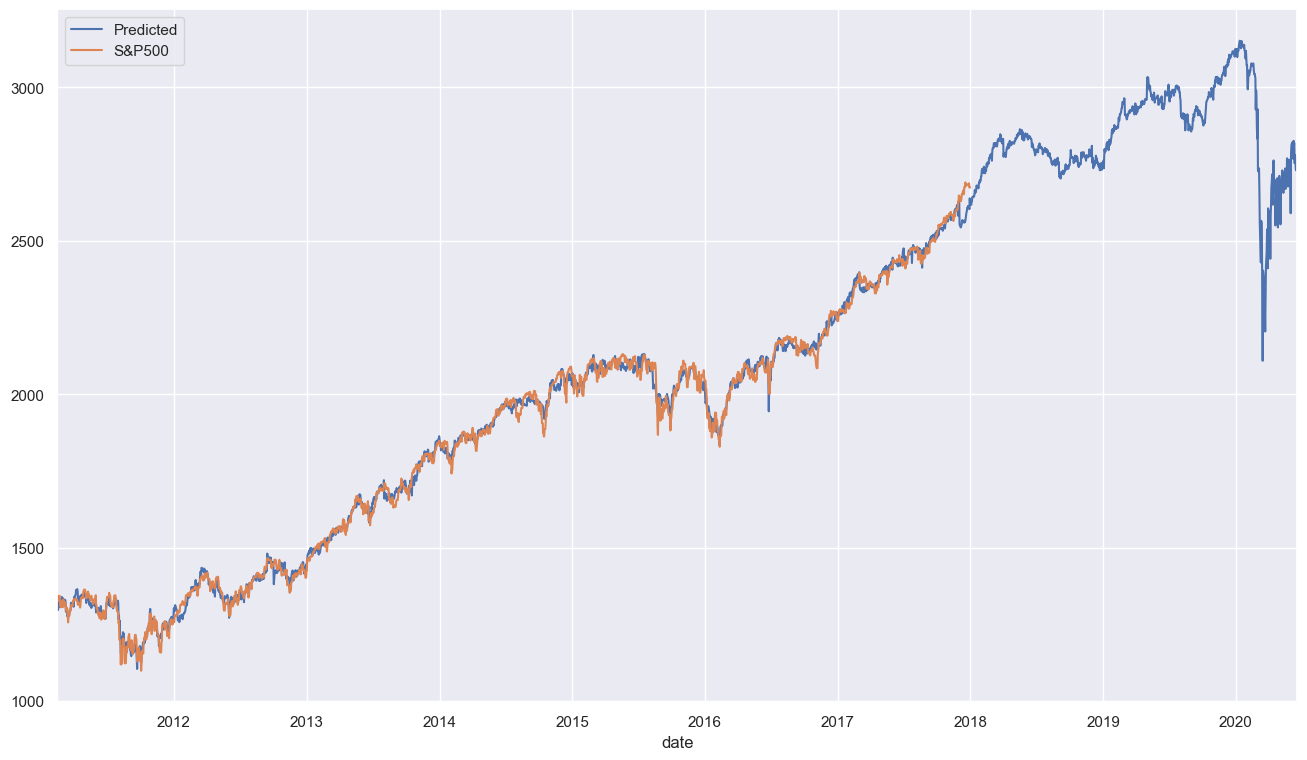

In [113]:
fig, ax = plt.subplots(figsize=(16, 9))
forecast.set_index(pd.to_datetime(forecast['ds']), inplace=True)
forecast['yhat'].plot(ax=ax, label="Predicted")
sp500.plot(ax=ax, label="S&P500")
ax.legend(loc='upper left')
ax.set_ylabel("S&P 500")
mu, s

We can see a sharp drop-off in 2020 that's predicted, presumably because of factors such as unemployment or the infectious disease index, or the general drop off in the Transportation and Services industries.

## Factor Analysis

In [30]:
# get factors from run
factors = pd.read_csv("factanal.csv")
factors.sort_values("coef", inplace=True)

<AxesSubplot:ylabel='regressor'>

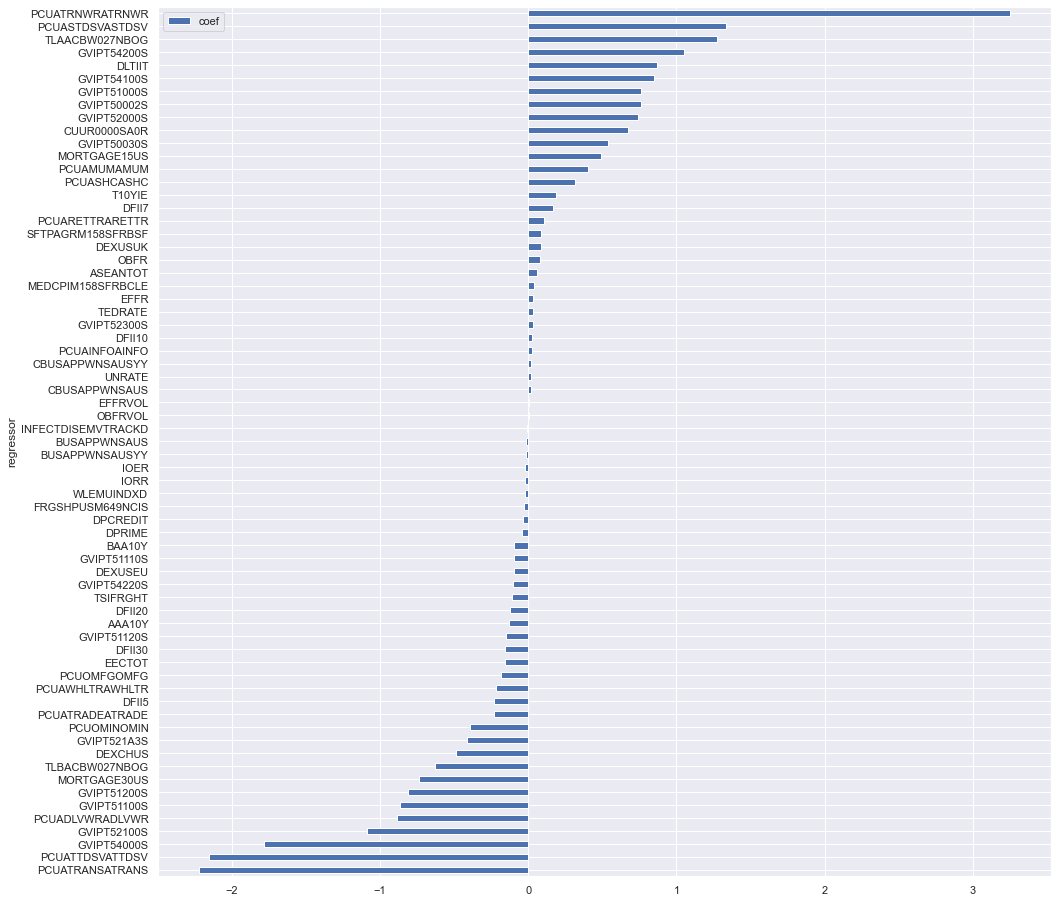

In [32]:
fig, ax = plt.subplots(figsize=(16, 16))
pcucols = ["PCUADLVWRADLVWR",
"PCUAINFOAINFO",
"PCUAMUMAMUM",
"PCUARETTRARETTR",
"PCUASHCASHC",
"PCUASTDSVASTDSV",
"PCUATRADEATRADE",
"PCUATRANSATRANS",
"PCUATRNWRATRNWR",
"PCUATTDSVATTDSV",
"PCUAWHLTRAWHLTR",
"PCUOMFGOMFG",
"PCUOMINOMIN"]
factors.plot.barh('regressor', 'coef', ax=ax)

In [50]:
top_cols = factors.sort_values("abs_coef", ascending=False)['regressor'].values

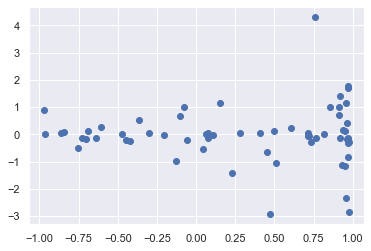

In [33]:
t = pd.concat([normed_obs.corr()['SP500'], normalize(factors.set_index("regressor")['coef'])], axis=1)
plt.scatter(t.SP500, t.coef)

Interesting finding: It appears that correlation to the S&P500 doesn't inform the a given series's contribution to the Prophet model. This suggests that Prophet is learning new information that is time-invariant from each feature provided, which is a very good thing.

# Model Optimization

## Selecting number of factors

We want anywhere from the top 1 to top 15 factors (in coefficient magnitude) in our model + infectious disease tracking, because we find it's useful for pandemic time periods.

In [34]:
from prophet.diagnostics import performance_metrics, cross_validation

In [36]:
def eval_model(f):
    """train and evaluate model crossvalidation on f factors."""
    m = Prophet(changepoint_prior_scale=0.1, seasonality_prior_scale=0.01)
    feat, _, _ = columnCleaner("data/observations_train.csv", columns=f)
    dropped_cols = ["DEXJPUS", "SOFR", "SOFRVOL"]
    for c in f:
        if c not in dropped_cols:
            m.add_regressor(c, standardize=False)
    m.fit(feat)
    cv_1yr = cross_validation(m, initial='365 days', period="180 days", horizon='1 day', parallel='processes')
    cv_1mo = cross_validation(m, initial='30 days', period="180 days", horizon='1 day', parallel='processes')
    cv_1wk = cross_validation(m, initial='7 days', period="180 days", horizon='1 day', parallel='processes')
    
    perf_1yr = performance_metrics(cv_1yr).iloc[0]['mape']
    perf_1mo = performance_metrics(cv_1mo).iloc[0]['mape']
    perf_1wk = performance_metrics(cv_1wk).iloc[0]['mape']
    
    return [perf_1wk, perf_1mo, perf_1yr]

def run_models(i):
    """run the models."""
    fctrs = top_cols[:i]
    fctrs3 = np.append(fctrs, 'INFECTDISEMVTRACKD')
    three = eval_model(fctrs3)
    return three

# NOTE: Takes ~10 mins to run, do not uncomment unless you have lots of time! 
# We'll just pull our saved data to show you the results
# for i in range(1, 16):
#     print("Now Running:", i)
#     perfs.append(run_models(i))

        Week     Month      Year
0   0.160057  0.160057  0.184555
1   0.125416  0.125416  0.144136
2   0.153408  0.153408  0.176897
3   0.162390  0.162390  0.187181
4   0.211274  0.211274  0.244059
5   0.201076  0.201076  0.231941
6   0.204007  0.204007  0.235440
7   0.239490  0.239490  0.276469
8   0.101424  0.101424  0.115505
9   0.116150  0.116150  0.133180
10  0.112771  0.112771  0.130582
11  0.108750  0.108750  0.125876
12  0.202550  0.202550  0.235319
13  0.202943  0.202943  0.235907
14  0.219353  0.219353  0.254883


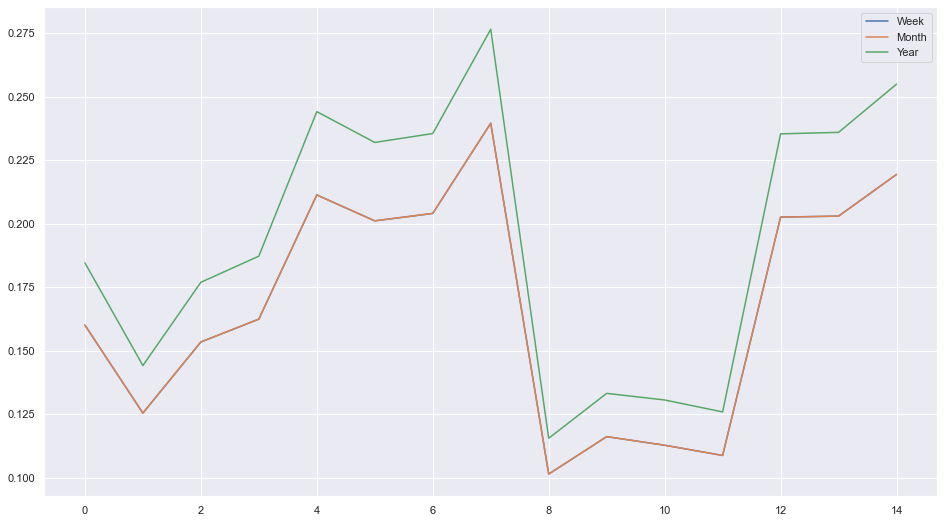

In [42]:
perfs = pd.read_csv("model_perfs.csv", index_col=0)
print(perfs)
fig, ax = plt.subplots(figsize=(16, 9))
perfs.plot(ax=ax)
plt.show()

Tests show that 8-10 top components, + Infectious Disease, work across the board in almost halving MAPE.

## Hyperparameter Optimization

We want to change the sensitivity to seasonality and changepoints for each model to make them more accurate.

In [45]:
import itertools

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
mapes_yr = []  # Store the MAPEs for each params here
mapes_mo = []
mapes_wk = []


# NOTE: Same thing as above, this takes a while to run. 
# We have cached data we will use for the remainded of the notebook.
# # Use cross validation to evaluate all parameters
# for params in all_params:
#     m_yr = Prophet(**params).fit(feat)  # Fit model with given params
#     m_mo = Prophet(**params).fit(feat)
#     m_wk = Prophet(**params).fit(feat)
#     df_cv_yr = cross_validation(m_yr, initial="365 days", period="330 days", horizon='1 day', parallel="processes")
#     df_cv_mo = cross_validation(m_mo, initial="30 days", period="330 days", horizon='1 day', parallel="processes")
#     df_cv_wk = cross_validation(m_wk, initial="7 days", period="330 days", horizon='1 day', parallel="processes")
    
#     df_p_yr = performance_metrics(df_cv_yr)
#     df_p_mo = performance_metrics(df_cv_mo)
#     df_p_wk = performance_metrics(df_cv_wk)
#     mapes_yr.append(df_p_yr['mape'].values[0])
#     mapes_mo.append(df_p_mo['mape'].values[0])
#     mapes_wk.append(df_p_wk['mape'].values[0])

In [47]:
tuning_results = pd.read_csv("tuning_results.csv")
tuning_results

,changepoint_prior_scale,seasonality_prior_scale,mape - 1yr,mape - 1mo,mape - 1wk,mape - avg
0,0.001,0.01,0.404979,0.356223,0.356223,0.372475
1,0.001,0.10,0.380059,0.335100,0.335100,0.350086
2,0.001,1.00,0.385848,0.340171,0.340171,0.355397
3,0.001,10.00,0.399376,0.355220,0.355220,0.369939
4,0.010,0.01,0.255733,0.224863,0.224863,0.235153
5,0.010,0.10,0.264668,0.231684,0.231684,0.242679
6,0.010,1.00,0.262809,0.231730,0.231730,0.242090
7,0.010,10.00,0.267770,0.236048,0.236048,0.246622
8,0.100,0.01,0.095412,0.086615,0.086615,0.089547
9,0.100,0.10,0.119173,0.105242,0.105242,0.109886


seasonality_prior_scale,0.01,0.10,1.00,10.00
changepoint_prior_scale,,,,
0.001,0.372475,0.350086,0.355397,0.369939
0.010,0.235153,0.242679,0.242090,0.246622
0.100,0.089547,0.109886,0.112136,0.112708
0.500,0.133463,0.179005,0.185323,0.183209


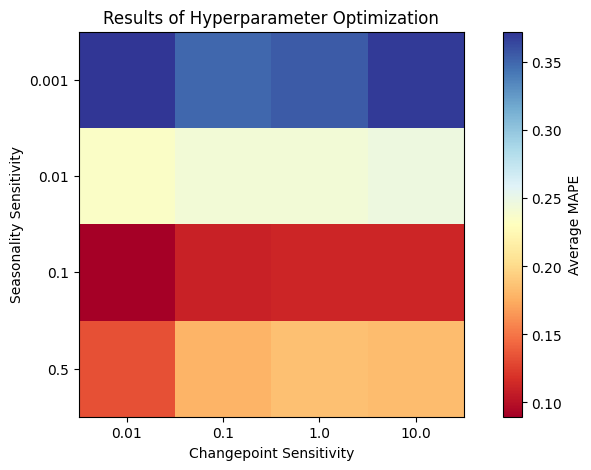

In [48]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

ptable = tuning_results[['changepoint_prior_scale', 
                         'seasonality_prior_scale', 
                         'mape - avg']].pivot(values="mape - avg", index="changepoint_prior_scale", columns="seasonality_prior_scale")
plt.figure(figsize=(10, 5))
# tuning_results['mape - avg'].plot(ax=ax)
# ax.set_xlabel("Parameter Set Index")
# ax.set_ylabel("Average MAPE")
# ax.set_title("Results of Prophet Hyperparameter Optimization")
plt.imshow(ptable, cmap ="RdYlBu")
cbar = plt.colorbar()
cbar.set_label('Average MAPE', rotation=90, loc='center')
plt.xticks(range(len(ptable)), ptable.columns)
plt.yticks(range(len(ptable)), ptable.index)
plt.xlabel("Changepoint Sensitivity")
plt.ylabel("Seasonality Sensitivity")
plt.title("Results of Hyperparameter Optimization")
ptable

Conclusion: changepoint prior scale of 0.1 is clearly best, with lower seasonality prior appearing to work better (probably due to the relatively small amounts of data we're training with)

# Final Model Visualization

Not the prediction yet, that will be below in the next section.

In [114]:
final_model_1yr = Prophet(changepoint_prior_scale=0.1, seasonality_prior_scale=0.01)
final_model_1mo = Prophet(changepoint_prior_scale=0.1, seasonality_prior_scale=0.01)
final_model_1wk = Prophet(changepoint_prior_scale=0.001, seasonality_prior_scale=0.01)

f = [*top_cols[:9], 'INFECTDISEMVTRACKD']
feat, mu, s = columnCleaner("data/observations_train.csv", columns=f, normalize_sp5=False)
cutoff = 500
train_yr = feat.iloc[-(cutoff+365):-cutoff]
test_yr = feat.iloc[-cutoff:]
train_mo = feat.iloc[-(cutoff+30):-cutoff]
test_mo = feat.iloc[-cutoff:]
train_wk = feat.iloc[-(cutoff+7):-cutoff]
test_wk = feat.iloc[-cutoff:]
dropped_cols = ["DEXJPUS", "SOFR", "SOFRVOL"]
for c in f:
    if c not in dropped_cols:
        final_model_1yr.add_regressor(c, standardize=False)
        final_model_1mo.add_regressor(c, standardize=False)
        final_model_1wk.add_regressor(c, standardize=False)

final_model_1yr.fit(train_yr)
final_model_1mo.fit(train_mo)
final_model_1wk.fit(train_wk)
# cv = cross_validation(final_model, initial="30 days", period="10 days", horizon="1 day", parallel="processes")

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 16.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.


In [115]:
pred_yr = final_model_1yr.predict(test_yr.drop(columns="y"))
pred_mo = final_model_1mo.predict(test_mo.drop(columns="y"))
pred_wk = final_model_1wk.predict(test_wk.drop(columns="y"))

pred_yr.set_index("ds", inplace=True)
pred_mo.set_index("ds", inplace=True)
pred_wk.set_index("ds", inplace=True)

pred_yr.head()

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,GVIPT52100S,GVIPT52100S_lower,GVIPT52100S_upper,GVIPT54000S,GVIPT54000S_lower,...,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,,,,,,,
2016-08-19,2181.358957,2153.114953,2217.170398,2181.358957,2181.358957,-62.921698,-62.921698,-62.921698,-0.599219,-0.599219,...,5.028117,5.028117,5.028117,-0.453281,-0.453281,-0.453281,0.0,0.0,0.0,2185.933793
2016-08-20,2182.262341,2157.331543,2219.672966,2182.262341,2182.262341,-62.921698,-62.921698,-62.921698,-0.599219,-0.599219,...,5.028117,5.028117,5.028117,0.252860,0.252860,0.252860,0.0,0.0,0.0,2187.543317
2016-08-21,2183.165724,2157.055926,2220.522984,2183.165724,2183.165724,-62.921698,-62.921698,-62.921698,-0.599219,-0.599219,...,5.028117,5.028117,5.028117,0.252860,0.252860,0.252860,0.0,0.0,0.0,2188.446701
2016-08-22,2184.069108,2154.771347,2220.349258,2184.001936,2184.118547,-62.921698,-62.921698,-62.921698,-0.599219,-0.599219,...,5.028117,5.028117,5.028117,-2.071488,-2.071488,-2.071488,0.0,0.0,0.0,2187.025736
2016-08-23,2184.972491,2156.552642,2220.145717,2184.569330,2185.458595,-62.921698,-62.921698,-62.921698,-0.599219,-0.599219,...,4.889446,4.889446,4.889446,-2.281296,-2.281296,-2.281296,0.0,0.0,0.0,2187.580641


/Users/arunavgupta/anaconda3/envs/dh21/lib/python3.8/site-packages/pandas/core/series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


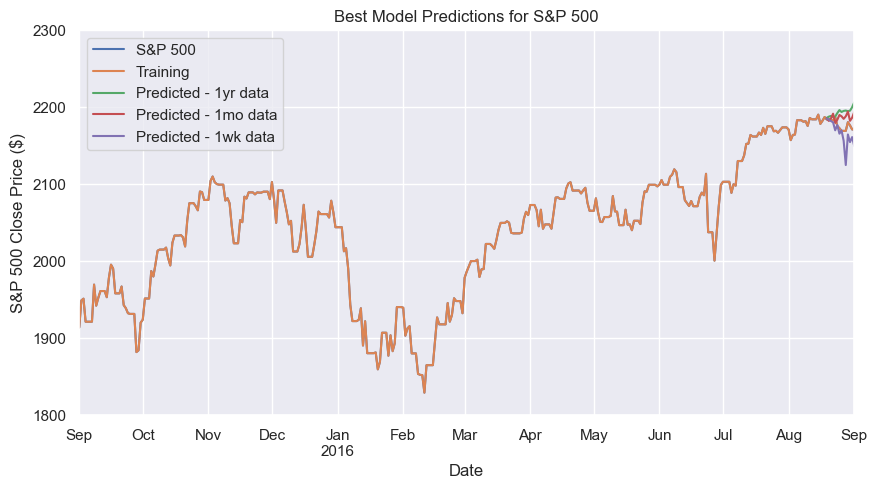

In [118]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.set()
# real S&P500
pivoted = observations.pivot_table(values="value", index="date", columns="series_id")
pivoted.set_index(pd.to_datetime(pivoted.index), inplace=True)
sp500 = pivoted.loc[pivoted.index >= "2011-02-14"]['SP500']
sp500.fillna(method="ffill", inplace=True)
sp500.plot(ax=ax, label="S&P 500")


#training data
sp500.plot(ax=ax, label="Training")

#predictions
pred_yr['yhat'].plot(ax=ax, label="Predicted - 1yr data")
pred_mo['yhat'].plot(ax=ax, label="Predicted - 1mo data")
pred_wk['yhat'].plot(ax=ax, label="Predicted - 1wk data")


ax.legend(loc='upper left')
ax.set_xlim(['2015-09-01', '2016-09-01'])
ax.set_xlabel("Date")
ax.set_ylabel("S&P 500 Close Price ($)")
ax.set_title("Best Model Predictions for S&P 500")
ax.set_ylim([1800, 2300])
plt.show()

We can see how the lack of data in the 1wk model adversely affects the prediction. It just so happens that there is a sharp drop on the Thursday of our training data, so the model wants to believe a changepoint has occurred and that the market will continue to decline in subsequent weeks. Not unlike a novice investor who has only been in the market for one week!

# Final Predictions

Dates to predict:
- DATE1: JAN 10, 2020

- DATE2: MARCH 6, 2020

- DATE3: JUL 12, 2019


In [89]:
# date 1
d1_model_1yr = Prophet(changepoint_prior_scale=0.1, seasonality_prior_scale=0.01)
d1_model_1mo = Prophet(changepoint_prior_scale=0.1, seasonality_prior_scale=0.01)
d1_model_1wk = Prophet(changepoint_prior_scale=0.001, seasonality_prior_scale=0.01)

In [90]:
# date 2
d2_model_1yr = Prophet(changepoint_prior_scale=0.1, seasonality_prior_scale=0.01)
d2_model_1mo = Prophet(changepoint_prior_scale=0.1, seasonality_prior_scale=0.01)
d2_model_1wk = Prophet(changepoint_prior_scale=0.001, seasonality_prior_scale=0.01)

In [91]:
# date 3
d3_model_1yr = Prophet(changepoint_prior_scale=0.1, seasonality_prior_scale=0.01)
d3_model_1mo = Prophet(changepoint_prior_scale=0.1, seasonality_prior_scale=0.01)
d3_model_1wk = Prophet(changepoint_prior_scale=0.001, seasonality_prior_scale=0.01)